# Simple LSTM - SP500

In [ ]:
# used ChatGPT to debug some functions

'''
Sources
linear regression: https://www.youtube.com/watch?v=OXwZtlcTiuk&t=69s
lstm: https://www.youtube.com/watch?v=CbTU92pbDKw
'''

#### Import Libraries

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

### Data Preparation

#### Download Data from yFinance

In [2]:
# Scrape S&P 500 tickers from Wikipedia
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_table = pd.read_html(url)[0]
sp500_tickers = sp500_table['Symbol'].tolist()

In [3]:
# Set date range for 20 years
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=10 * 365)

# download dataset
df = yf.download(sp500_tickers, start=start_date, end=end_date, group_by="ticker")

df

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2014-12-13 14:58:35.088593 -> 2024-12-10 14:58:35.088593)')


Ticker                            SW                                   \
Price                           Open       High        Low      Close   
Date                                                                    
2014-12-15 00:00:00+00:00        NaN        NaN        NaN        NaN   
2014-12-16 00:00:00+00:00        NaN        NaN        NaN        NaN   
2014-12-17 00:00:00+00:00        NaN        NaN        NaN        NaN   
2014-12-18 00:00:00+00:00        NaN        NaN        NaN        NaN   
2014-12-19 00:00:00+00:00        NaN        NaN        NaN        NaN   
...                              ...        ...        ...        ...   
2024-12-03 00:00:00+00:00  55.310001  55.400002  54.599998  55.220001   
2024-12-04 00:00:00+00:00  55.500000  55.500000  54.330002  54.570000   
2024-12-05 00:00:00+00:00  54.689999  54.849998  54.080002  54.770000   
2024-12-06 00:00:00+00:00  54.790001  54.950001  54.439999  54.610001   
2024-12-09 00:00:00+00:00  55.009998  55.180000  54.110001  54.340000   

Ticker                                                HOLX             \
Price                      Adj Close     Volume       Open       High   
Date                                                                    
2014-12-15 00:00:00+00:00        NaN        NaN  25.980000  26.219999   
2014-12-16 00:00:00+00:00        NaN        NaN  25.360001  25.950001   
2014-12-17 00:00:00+00:00        NaN        NaN  25.750000  26.389999   
2014-12-18 00:00:00+00:00        NaN        NaN  26.910000  26.980000   
2014-12-19 00:00:00+00:00        NaN        NaN  26.930000  27.100000   
...                              ...        ...        ...        ...   
2024-12-03 00:00:00+00:00  55.220001  2630100.0  78.980003  78.980003   
2024-12-04 00:00:00+00:00  54.570000  2891900.0  77.959999  77.959999   
2024-12-05 00:00:00+00:00  54.770000  2428900.0  76.709999  76.849998   
2024-12-06 00:00:00+00:00  54.610001  1633300.0  75.980003  76.419998   
2024-12-09 00:00:00+00:00  54.340000  2568200.0  75.839996  76.250000   

Ticker                                           ...        AMZN              \
Price                            Low      Close  ...         Low       Close   
Date                                             ...                           
2014-12-15 00:00:00+00:00  25.400000  25.600000  ...   15.107500   15.303500   
2014-12-16 00:00:00+00:00  25.260000  25.639999  ...   14.750500   14.753000   
2014-12-17 00:00:00+00:00  25.660000  26.370001  ...   14.651500   14.944000   
2014-12-18 00:00:00+00:00  26.490000  26.959999  ...   14.662500   14.886500   
2014-12-19 00:00:00+00:00  26.809999  26.930000  ...   14.776000   14.995000   
...                              ...        ...  ...         ...         ...   
2024-12-03 00:00:00+00:00  77.379997  77.470001  ...  209.649994  213.440002   
2024-12-04 00:00:00+00:00  76.279999  76.870003  ...  215.750000  218.160004   
2024-12-05 00:00:00+00:00  75.610001  76.000000  ...  217.300003  220.550003   
2024-12-06 00:00:00+00:00  75.220001  75.339996  ...  220.600006  227.029999   
2024-12-09 00:00:00+00:00  74.440002  75.790001  ...  225.669998  226.089996   

Ticker                                                   SNA              \
Price                       Adj Close     Volume        Open        High   
Date                                                                       
2014-12-15 00:00:00+00:00   15.303500   76832000  133.529999  134.429993   
2014-12-16 00:00:00+00:00   14.753000  130026000  132.289993  135.080002   
2014-12-17 00:00:00+00:00   14.944000   88670000  132.860001  134.419998   
2014-12-18 00:00:00+00:00   14.886500  154762000  136.369995  136.960007   
2014-12-19 00:00:00+00:00   14.995000  174182000  137.770004  137.830002   
...                               ...        ...         ...         ...   
2024-12-03 00:00:00+00:00  213.440002   32214800  366.690002  368.540009   
2024-12-04 00:00:00+00:00  218.160004   48745700  364.010010  366.839996 

#### Reformat the Data

In [4]:
# select only date and close columns for each ticker
df_selected = {}

# iterate through each ticker and select close data
for ticker in sp500_tickers:
    df_selected[ticker] = df[ticker][['Close']]

In [5]:
# Concatenate 'Close' values for all tickers into a single DataFrame
df_selected_all = pd.concat({ticker: df[ticker][['Close']] for ticker in sp500_tickers}, axis=1)

# Reset the column names to avoid multi-index columns
df_selected_all.columns = [f'{ticker}_Close' for ticker in df_selected_all.columns.get_level_values(0)]

df_selected_all

,MMM_Close,AOS_Close,ABT_Close,ABBV_Close,ACN_Close,ADBE_Close,AMD_Close,AES_Close,AFL_Close,A_Close,...,WY_Close,WMB_Close,WTW_Close,WYNN_Close,XEL_Close,XYL_Close,YUM_Close,ZBRA_Close,ZBH_Close,ZTS_Close
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-15 00:00:00+00:00,131.145493,26.730000,43.459999,65.620003,81.879997,73.040001,2.470000,13.01,28.764999,38.680000,...,35.590000,42.139999,115.231789,145.160004,34.250000,36.240002,50.776421,74.669998,107.048546,41.740002
2014-12-16 00:00:00+00:00,132.984955,26.535000,43.400002,65.250000,82.870003,72.320000,2.500000,12.79,28.905001,38.470001,...,34.740002,41.840000,114.993378,140.520004,34.220001,36.270000,49.618980,75.010002,105.621361,40.849998
2014-12-17 00:00:00+00:00,134.280930,27.055000,44.259998,66.570000,85.300003,74.000000,2.550000,13.13,29.535000,39.759998,...,35.009998,43.630001,118.225166,138.970001,34.750000,36.910000,50.754852,76.180000,108.660194,41.130001
2014-12-18 00:00:00+00:00,138.210709,27.514999,45.770000,67.919998,89.739998,74.889999,2.550000,13.21,30.160000,40.700001,...,35.299999,44.799999,118.384109,145.100006,35.349998,38.099998,51.574406,77.949997,111.592232,43.150002
2014-12-19 00:00:00+00:00,138.361206,27.230000,46.049999,67.709999,90.510002,74.449997,2.570000,13.50,30.590000,41.380001,...,36.189999,46.000000,119.205299,150.110001,35.400002,38.590000,51.164631,78.099998,111.563110,43.509998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-03 00:00:00+00:00,131.149994,74.019997,116.290001,181.500000,352.540009,516.260010,141.979996,13.05,106.760002,139.279999,...,31.719999,56.599998,329.059998,93.760002,71.000000,127.690002,137.720001,406.399994,110.739998,176.940002
2024-12-04 00:00:00+00:00,130.449997,73.599998,115.970001,176.460007,360.029999,536.489990,143.990005,13.43,106.989998,140.199997,...,31.240000,56.299999,332.529999,94.790001,70.720001,127.540001,138.160004,411.940002,110.620003,175.320007
2024-12-05 00:00:00+00:00,133.330002,72.320000,115.589996,176.169998,358.130005,538.219971,141.360001,13.29,107.750000,137.869995,...,30.959999,57.160000,330.000000,94.400002,70.860001,126.230003,138.130005,404.980011,109.160004,174.770004


In [6]:
# Calculate the average of the 'Close' columns across each row
df_selected_all.loc[:, 'avg_close'] = df_selected_all.mean(axis=1)

# Drop the individual 'Close' columns for each ticker
df_final = df_selected_all[['avg_close']]

df_final

/var/folders/cl/x4g3r0nj7qvb_h2ft5kt0zhw0000gn/T/ipykernel_73145/2052341422.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_selected_all.loc[:, 'avg_close'] = df_selected_all.mean(axis=1)


,avg_close
Date,
2014-12-15 00:00:00+00:00,70.612362
2014-12-16 00:00:00+00:00,70.053221
2014-12-17 00:00:00+00:00,71.519444
2014-12-18 00:00:00+00:00,73.092746
2014-12-19 00:00:00+00:00,73.443230
...,...
2024-12-03 00:00:00+00:00,231.248732
2024-12-04 00:00:00+00:00,231.289512
2024-12-05 00:00:00+00:00,229.800159


In [7]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2513 entries, 2014-12-15 00:00:00+00:00 to 2024-12-09 00:00:00+00:00
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   avg_close  2513 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [8]:
# remove timezone
df_final.index = pd.to_datetime(df.index).tz_localize(None)

df_final

,avg_close
Date,
2014-12-15,70.612362
2014-12-16,70.053221
2014-12-17,71.519444
2014-12-18,73.092746
2014-12-19,73.443230
...,...
2024-12-03,231.248732
2024-12-04,231.289512
2024-12-05,229.800159


#### EDA

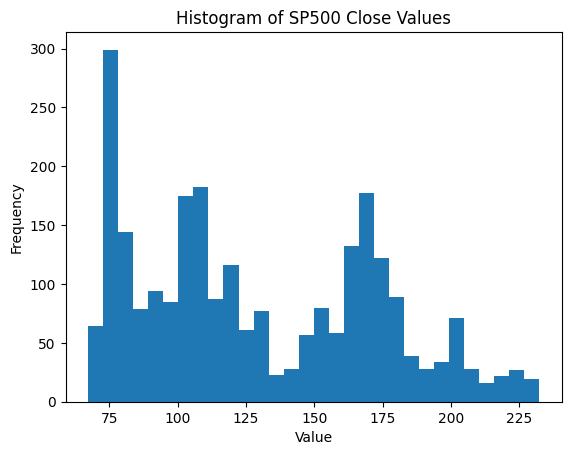

In [9]:
# plot histogram of close values
plt.hist(df_final['avg_close'], bins=30)
plt.title(f'Histogram of SP500 Close Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

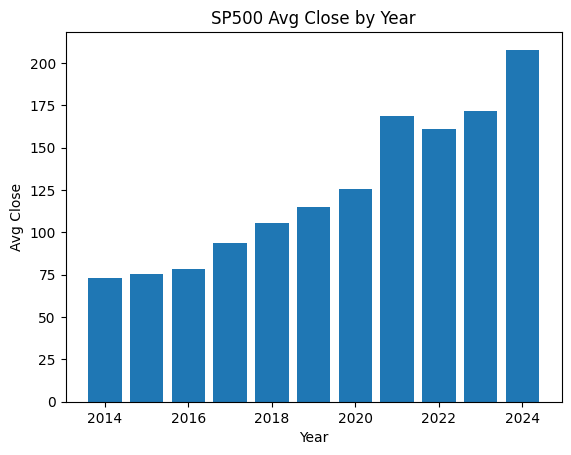

In [10]:
# plot histogram of mean close values by year
df_year = df_final.copy()
df_year.loc[:, 'year'] = df_year.index.year

# group by year and calculate mean
data_grouped = df_year.groupby('year').mean()

plt.bar(data_grouped.index, data_grouped['avg_close'])
plt.title('SP500 Avg Close by Year')
plt.xlabel('Year')
plt.ylabel('Avg Close')
plt.show()

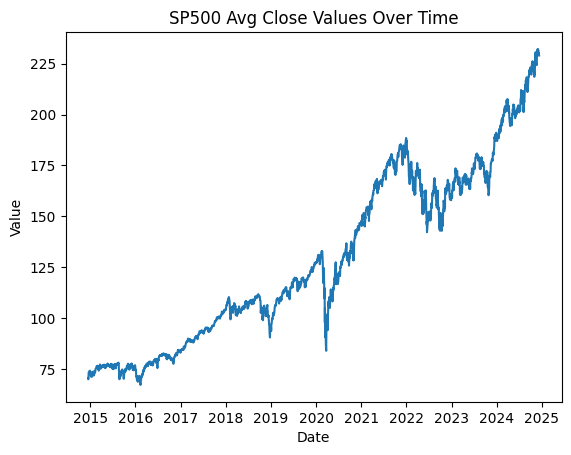

In [11]:
# plot the close values over time
plt.plot(df_final.index, df_final['avg_close'])
plt.title(f'SP500 Avg Close Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

## Time Period Used: 10 years

### Linear Regression

In [101]:
# set max date as end_date
end_date_1 = df_final.index.max()

# set min date as start_date
start_date_1 = df_final.index[3]  # get the 4th value (necessary for lstm)

start_date_1, end_date_1

(Timestamp('2014-12-18 00:00:00'), Timestamp('2024-12-09 00:00:00'))

In [102]:
# drop rows not in start and end range
df_lr = df_final[(df_final.index >= start_date_1) & (df_final.index <= end_date_1)]

df_lr

,avg_close
Date,
2014-12-18,73.092746
2014-12-19,73.443230
2014-12-22,73.783538
2014-12-23,73.882196
2014-12-24,73.955113
...,...
2024-12-03,231.248732
2024-12-04,231.289512
2024-12-05,229.800159


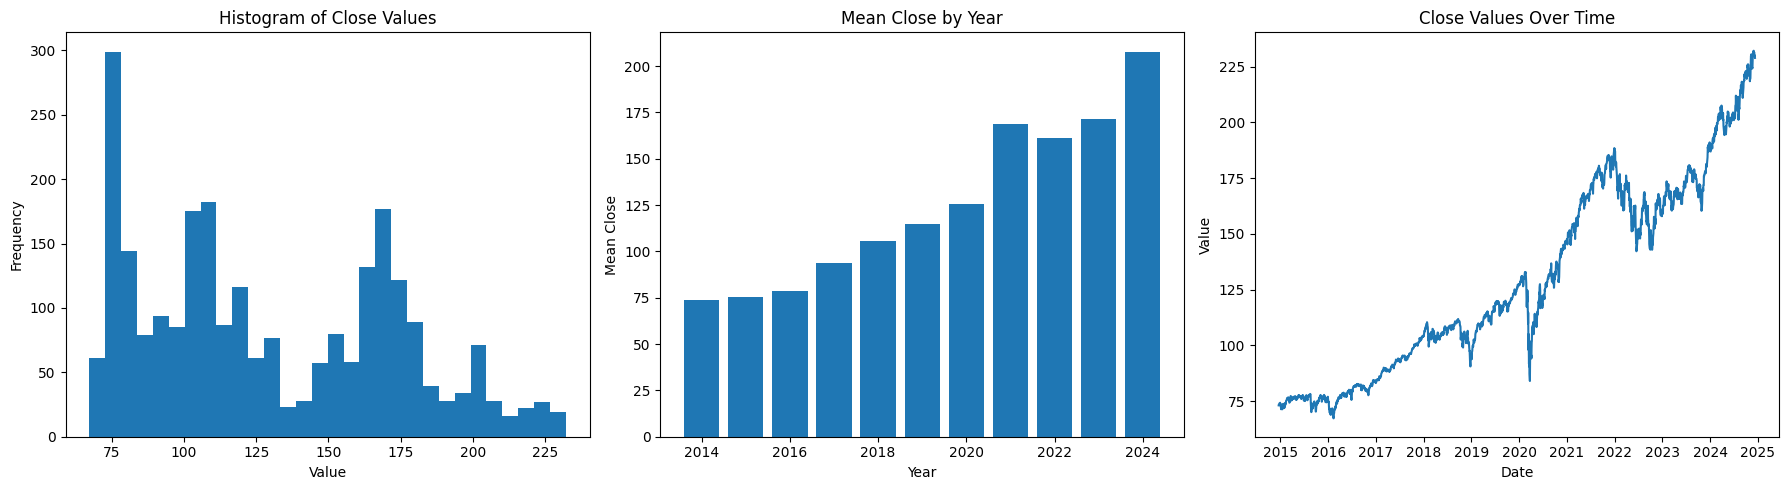

In [103]:
# create a 1x3 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # Adjust the figure size as needed

# plot histogram of close values
axs[0].hist(df_lr['avg_close'], bins=30)
axs[0].set_title('Histogram of Close Values')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

# plot histogram of mean close values by year
df_year = df_lr.copy()
df_year.loc[:, 'year'] = df_year.index.year

# group by year and calculate mean
data_grouped = df_year.groupby('year').mean()

axs[1].bar(data_grouped.index, data_grouped['avg_close'])
axs[1].set_title('Mean Close by Year')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Mean Close')

# plot the close values over time
axs[2].plot(df_lr.index, df_lr['avg_close'])
axs[2].set_title('Close Values Over Time')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [104]:
# split the data into train and test sets
df_lm = df_final.reset_index()
X = np.array(df_lm.index).reshape(-1,1)
Y = df_lm['avg_close']
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, Y, test_size=0.3, random_state=123)

In [105]:
print(X_train_lr.shape)
print(X_test_lr.shape)
print(y_train_lr.shape)
print(y_test_lr.shape)

(1759, 1)
(754, 1)
(1759,)
(754,)


In [106]:
# create linear model
lm = LinearRegression()
lm.fit(X_train_lr, y_train_lr)

LinearRegression()

In [107]:
# predict using the trained model
y_pred_lr = lm.predict(X_test_lr)

In [108]:
# sort index to maintain alignment with predictions
sorted_indices = np.argsort(X_test_lr.flatten())  # get sorted indices
y_test_sorted = y_test_lr.iloc[sorted_indices]    # sort test data
y_pred_sorted = y_pred_lr[sorted_indices]         # sort predictions

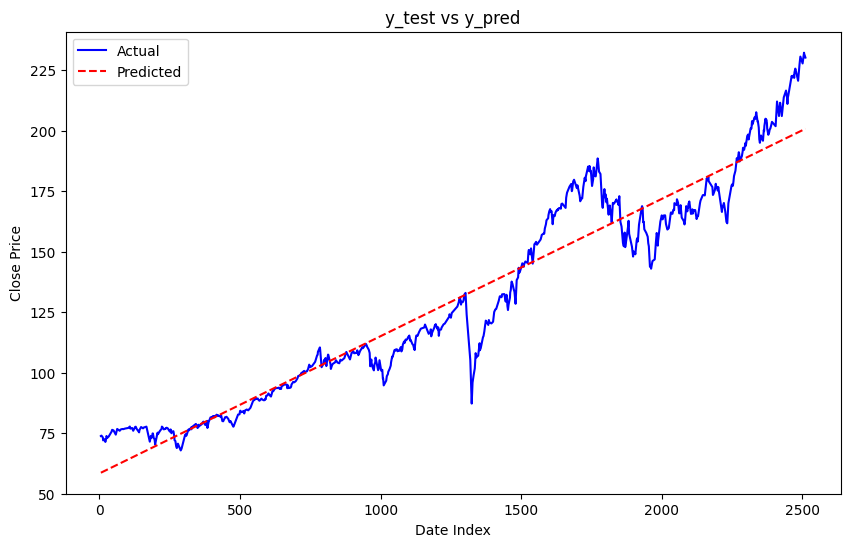

In [109]:
# plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_sorted.index, y_test_sorted, label='Actual', color='blue')
plt.plot(y_test_sorted.index, y_pred_sorted, label='Predicted', color='red', linestyle='--')

plt.title('y_test vs y_pred')
plt.xlabel('Date Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [110]:
# calculate scores and store them in a dictionary
evaluation_scores = {
    'Metric': ['r2_score', 'MSE'],
    'Train': [
        r2_score(y_train_lr, lm.predict(X_train_lr)),
        mse(y_train_lr, lm.predict(X_train_lr))
    ],
    'Test': [
        r2_score(y_test_lr, lm.predict(X_test_lr)),
        mse(y_test_lr, lm.predict(X_test_lr))
    ]
}

# convert the dictionary to a df and print
eval_scores_df = pd.DataFrame(evaluation_scores)
eval_scores_df.style.hide(axis="index")

Metric,Train,Test
r2_score,0.925407,0.924761
MSE,138.619551,137.897163


### LSTM

In [111]:
# define function to convert string to datetime
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [112]:
# define function to create lstm data structure
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['avg_close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

In [113]:
# convert start and end date to strings
end_date_str = end_date_1.strftime('%Y-%m-%d')
start_date_str = start_date_1.strftime('%Y-%m-%d')

In [114]:
# create lstm data structure
windowed_df = df_to_windowed_df(df_final, 
                                start_date_str, 
                                end_date_str, 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2014-12-18,70.612362,70.053221,71.519444,73.092746
1,2014-12-19,70.053221,71.519444,73.092746,73.443230
2,2014-12-22,71.519444,73.092746,73.443230,73.783538
3,2014-12-23,73.092746,73.443230,73.783538,73.882196
4,2014-12-24,73.443230,73.783538,73.882196,73.955113
...,...,...,...,...,...
2505,2024-12-03,231.535115,232.192305,231.537215,231.248732
2506,2024-12-04,232.192305,231.537215,231.248732,231.289512
2507,2024-12-05,231.537215,231.248732,231.289512,229.800159
2508,2024-12-06,231.248732,231.289512,229.800159,230.184870


Target is the close value for the target date. Target-3,2,1 are the three previous close values that came before the target date.

In [115]:
# select target and feature variables
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  # separate the dates
  dates = df_as_np[:, 0]

  # feature
  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))  # reshape for lstm input

  # target
  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((2510,), (2510, 3, 1), (2510,))

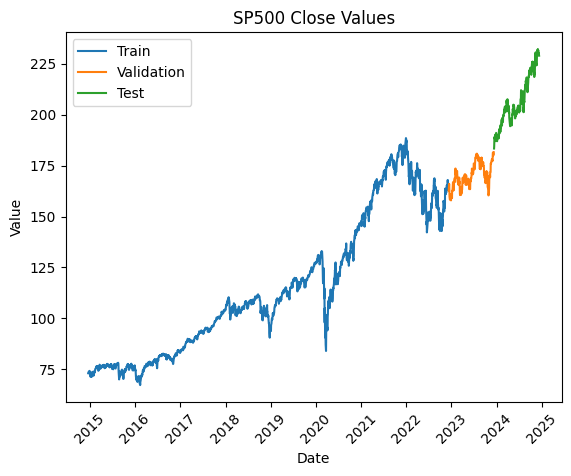

In [116]:
# split into training, validation, and test datasets
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]        # 80%

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]  # 10%
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]           # 10%

# plot the splits
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.title(f'SP500 Close Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(['Train', 'Validation', 'Test'])

plt.xticks(rotation=45)
plt.show()

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13459.8877 - mean_absolute_error: 111.0730 - val_loss: 24360.8125 - val_mean_absolute_error: 155.9704
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 10542.5820 - mean_absolute_error: 96.7646 - val_loss: 20091.9102 - val_mean_absolute_error: 141.6258
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 8101.5303 - mean_absolute_error: 83.4354 - val_loss: 16532.5723 - val_mean_absolute_error: 128.4466
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 6152.9233 - mean_absolute_error: 70.9201 - val_loss: 13727.6973 - val_mean_absolute_error: 117.0199
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 4742.2173 - mean_absolute_error: 60.0219 - val_loss: 11474.7510 - val_mean_absolute_error: 106.9612
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 3594.8184 - mean_absolute_error: 49.6804 - val_loss: 9658.9619 - val_mean_absolute_error: 98.1066
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 

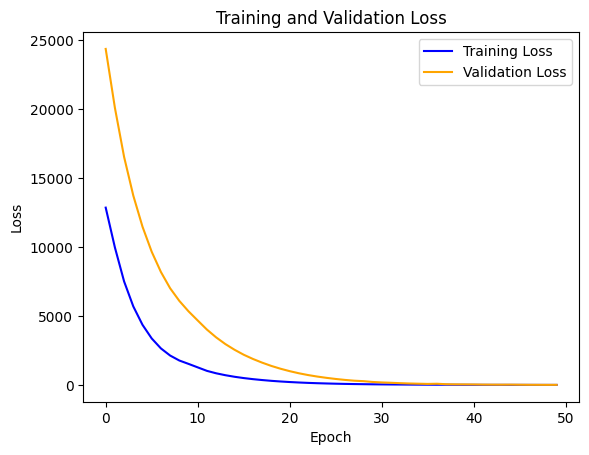

In [117]:
# build model
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(32),
                    layers.Dense(1)])

# compile model. select loss, optimizer, and learning rate
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.01),
              metrics=['mean_absolute_error'])

# fit model and set number of epochs
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

# plot loss per epoch
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14103.3672 - mean_absolute_error: 113.9181 - val_loss: 27210.6348 - val_mean_absolute_error: 164.8527
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 12441.4404 - mean_absolute_error: 106.1275 - val_loss: 19855.1348 - val_mean_absolute_error: 140.7864
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - loss: 7427.2510 - mean_absolute_error: 79.0865 - val_loss: 12905.7480 - val_mean_absolute_error: 113.4536
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 3929.1455 - mean_absolute_error: 52.3065 - val_loss: 7729.3931 - val_mean_absolute_error: 87.7232
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - loss: 1890.9062 - mean_absolute_error: 32.8885 - val_loss: 4870.6724 - val_mean_absolute_error: 69.5472
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 1144.8882 - mean_absolute_error: 25.8403 - val_loss: 3434.9827 - val_mean_absolute_error: 58.3218
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 649

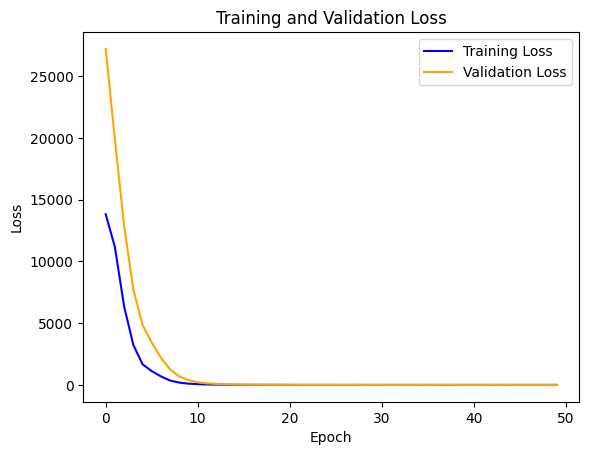

In [118]:
# tune model
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(32),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

# compile model. select loss, optimizer, and learning rate
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# fit model and set number of epochs
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

# plot loss per epoch
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [119]:
# get predictions
train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step


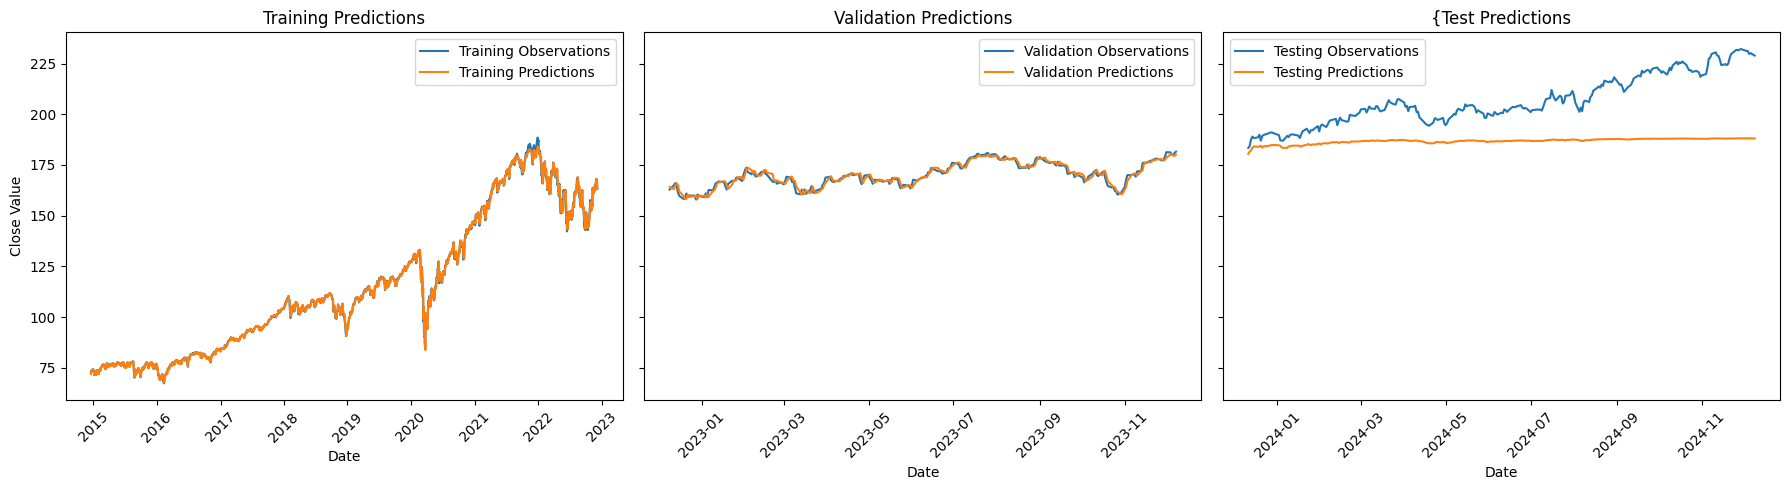

In [120]:
# 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)  # Share y-axis for easier comparison

# 1. plot training predictions
axes[0].plot(dates_train, y_train, label='Training Observations')
axes[0].plot(dates_train, train_predictions, label='Training Predictions')
axes[0].set_title('Training Predictions')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Close Value')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# 2. plot validation predictions
axes[1].plot(dates_val, y_val, label='Validation Observations')
axes[1].plot(dates_val, val_predictions, label='Validation Predictions')
axes[1].set_title('Validation Predictions')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

# 3. plot test predictions
axes[2].plot(dates_test, y_test, label='Testing Observations')
axes[2].plot(dates_test, test_predictions, label='Testing Predictions')
axes[2].set_title('{Test Predictions')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Result

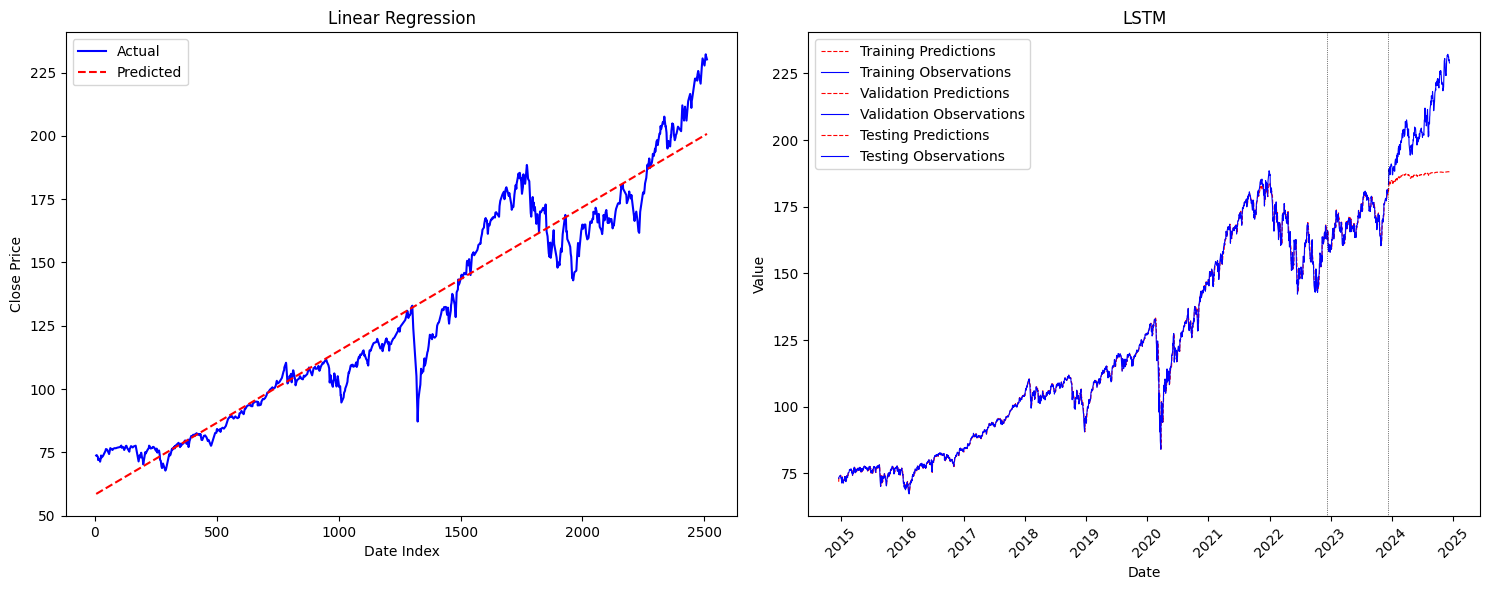

In [121]:
# create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. plot actual vs predicted
axes[0].plot(y_test_sorted.index, y_test_sorted, label='Actual', color='blue')
axes[0].plot(y_test_sorted.index, y_pred_sorted, label='Predicted', color='red', linestyle='--')
axes[0].set_title('Linear Regression')
axes[0].set_xlabel('Date Index')
axes[0].set_ylabel('Close Price')
axes[0].legend()

# 2. lstm predictions
axes[1].plot(dates_train, train_predictions, color='red', linestyle='--', linewidth=0.8)
axes[1].plot(dates_train, y_train, color='blue', linewidth=0.8)

axes[1].plot(dates_val, val_predictions, color='red', linestyle='--', linewidth=0.8)
axes[1].plot(dates_val, y_val, color='blue', linewidth=0.8)

axes[1].plot(dates_test, test_predictions, color='red', linestyle='--', linewidth=0.8)
axes[1].plot(dates_test, y_test, color='blue', linewidth=0.8)

# add a vertical dotted line between the training, validation, and test sets
split_train_val = dates_val[0]
split_val_test = dates_test[0]
axes[1].axvline(x=split_train_val, color='black', linestyle=':', linewidth=0.5)
axes[1].axvline(x=split_val_test, color='black', linestyle=':', linewidth=0.5)

axes[1].set_title('LSTM')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend(['Training Predictions', 
                'Training Observations',
                'Validation Predictions', 
                'Validation Observations',
                'Testing Predictions', 
                'Testing Observations'])

# Rotate x-axis ticks
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [122]:
# create dictionary to store mse for lr and lstm models
model_scores = {
    'Model': ['Linear Regression', 'LSTM'],
    'Train': [
        mse(y_train_lr, lm.predict(X_train_lr)),
        history.history['loss'][-1]
    ],
    'Test': [
        mse(y_test_lr, lm.predict(X_test_lr)),
        mse(y_test, test_predictions)
    ]
}

# convert the dictionary to a df and print
model_scores_df = pd.DataFrame(model_scores)
model_scores_df.style.hide(axis="index")

Model,Train,Test
Linear Regression,138.619551,137.897163
LSTM,2.596015,520.579895


## Time Period Used: 2 Years

### Linear Regression

In [123]:
# set max date as end_date
end_date_2 = df_final.index.max()

# calculate start date
tentative_start_date_2 = end_date_2 - pd.DateOffset(years=2)  # select last 2 years

# find the closest valid start date
start_date_2 = df_final.index[df_final.index >= tentative_start_date_2].min()

start_date_2, end_date_2

(Timestamp('2022-12-09 00:00:00'), Timestamp('2024-12-09 00:00:00'))

In [124]:
# drop rows not in start and end range
df_lr = df_final[(df_final.index >= start_date_2) & (df_final.index <= end_date_2)]

df_lr

,avg_close
Date,
2022-12-09,162.823652
2022-12-12,164.987732
2022-12-13,166.049910
2022-12-14,164.900950
2022-12-15,161.389481
...,...
2024-12-03,231.248732
2024-12-04,231.289512
2024-12-05,229.800159


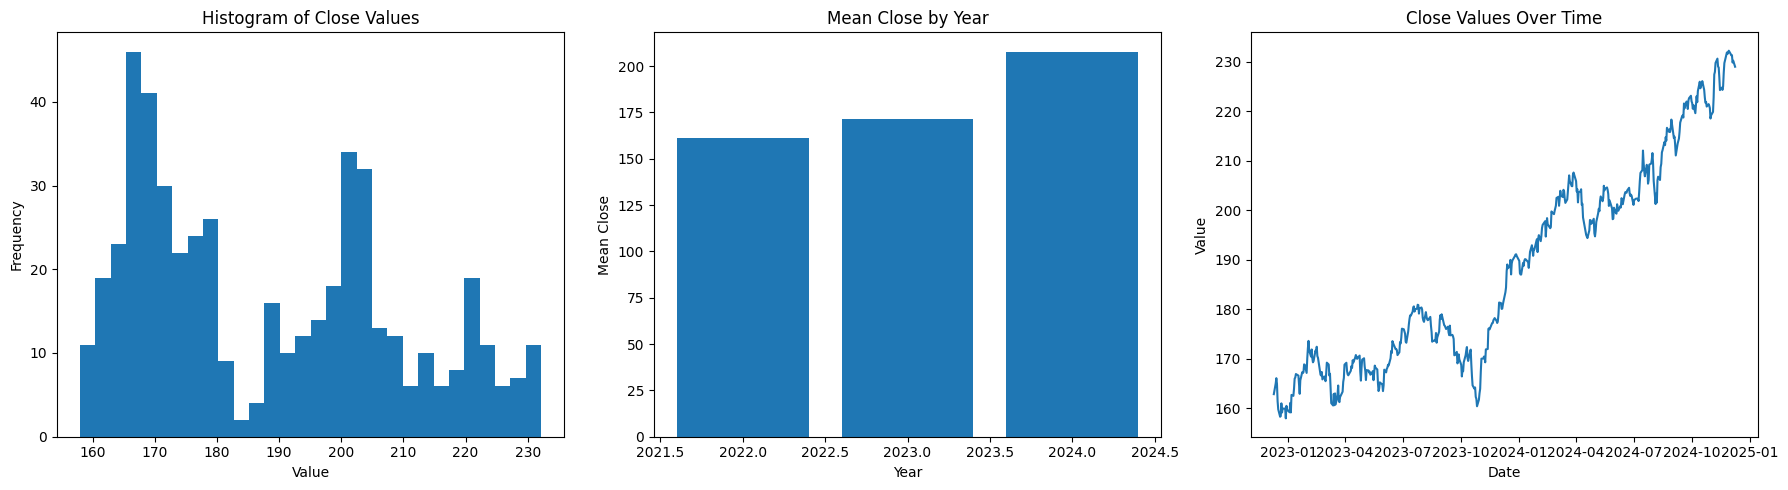

In [125]:
# create a 1x3 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # Adjust the figure size as needed

# plot histogram of close values
axs[0].hist(df_lr['avg_close'], bins=30)
axs[0].set_title('Histogram of Close Values')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

# plot histogram of mean close values by year
df_year = df_lr.copy()
df_year.loc[:, 'year'] = df_year.index.year

# group by year and calculate mean
data_grouped = df_year.groupby('year').mean()

axs[1].bar(data_grouped.index, data_grouped['avg_close'])
axs[1].set_title('Mean Close by Year')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Mean Close')

# plot the close values over time
axs[2].plot(df_lr.index, df_lr['avg_close'])
axs[2].set_title('Close Values Over Time')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [126]:
# split the data into train and test sets
df_lm = df_final.reset_index()
X = np.array(df_lm.index).reshape(-1,1)
Y = df_lm['avg_close']
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, Y, test_size=0.3, random_state=123)

In [127]:
print(X_train_lr.shape)
print(X_test_lr.shape)
print(y_train_lr.shape)
print(y_test_lr.shape)

(1759, 1)
(754, 1)
(1759,)
(754,)


In [128]:
# create linear model
lm = LinearRegression()
lm.fit(X_train_lr, y_train_lr)

LinearRegression()

In [129]:
# predict using the trained model
y_pred_lr = lm.predict(X_test_lr)

In [130]:
# sort index to maintain alignment with predictions
sorted_indices = np.argsort(X_test_lr.flatten())  # get sorted indices
y_test_sorted = y_test_lr.iloc[sorted_indices]    # sort test data
y_pred_sorted = y_pred_lr[sorted_indices]         # sort predictions

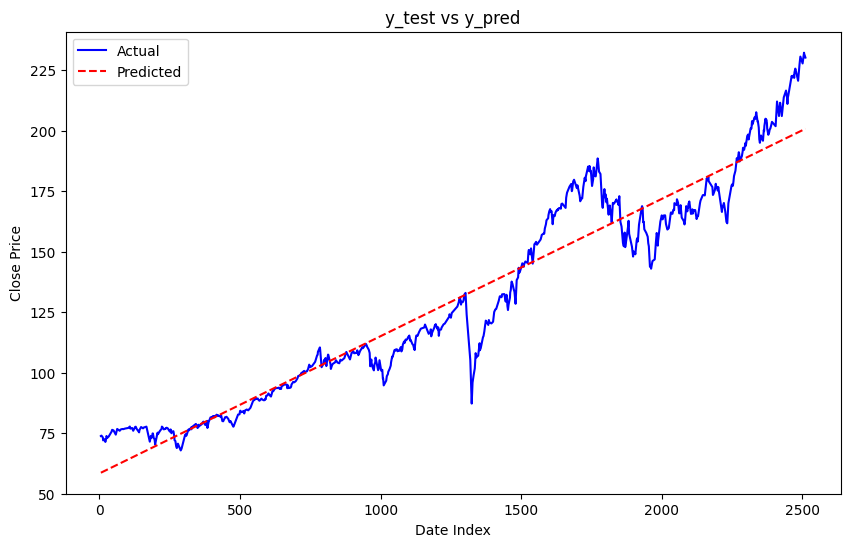

In [131]:
# plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_sorted.index, y_test_sorted, label='Actual', color='blue')
plt.plot(y_test_sorted.index, y_pred_sorted, label='Predicted', color='red', linestyle='--')

plt.title('y_test vs y_pred')
plt.xlabel('Date Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [132]:
# calculate scores and store them in a dictionary
evaluation_scores = {
    'Metric': ['r2_score', 'MSE'],
    'Train': [
        r2_score(y_train_lr, lm.predict(X_train_lr)),
        mse(y_train_lr, lm.predict(X_train_lr))
    ],
    'Test': [
        r2_score(y_test_lr, lm.predict(X_test_lr)),
        mse(y_test_lr, lm.predict(X_test_lr))
    ]
}

# convert the dictionary to a df and print
eval_scores_df = pd.DataFrame(evaluation_scores)
eval_scores_df.style.hide(axis="index")

Metric,Train,Test
r2_score,0.925407,0.924761
MSE,138.619551,137.897163


### LSTM

In [133]:
# convert start and end date to strings
end_date_str = end_date_2.strftime('%Y-%m-%d')
start_date_str = start_date_2.strftime('%Y-%m-%d')

In [134]:
# create lstm data structure
windowed_df = df_to_windowed_df(df_final, 
                                start_date_str, 
                                end_date_str, 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2022-12-09,163.017782,163.169770,164.315352,162.823652
1,2022-12-12,163.169770,164.315352,162.823652,164.987732
2,2022-12-13,164.315352,162.823652,164.987732,166.049910
3,2022-12-14,162.823652,164.987732,166.049910,164.900950
4,2022-12-15,164.987732,166.049910,164.900950,161.389481
...,...,...,...,...,...
497,2024-12-03,231.535115,232.192305,231.537215,231.248732
498,2024-12-04,232.192305,231.537215,231.248732,231.289512
499,2024-12-05,231.537215,231.248732,231.289512,229.800159
500,2024-12-06,231.248732,231.289512,229.800159,230.184870


In [135]:
# select target and feature variables
dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((502,), (502, 3, 1), (502,))

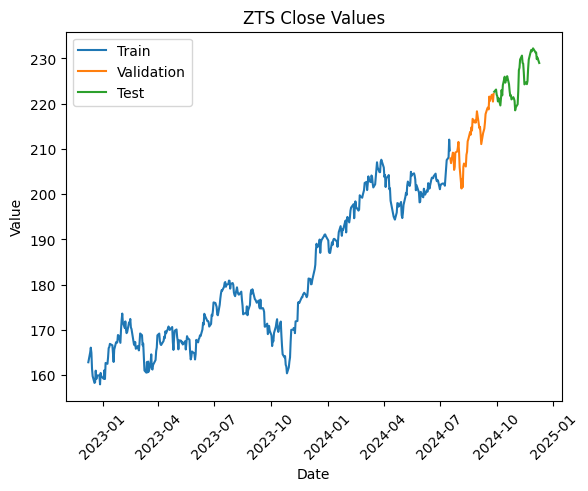

In [136]:
# split into training, validation, and test datasets
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]        # 80%

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]  # 10%
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]           # 10%

# plot the splits
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.title(f'{ticker} Close Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(['Train', 'Validation', 'Test'])

plt.xticks(rotation=45)
plt.show()

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 32753.5820 - mean_absolute_error: 180.3357 - val_loss: 43834.8984 - val_mean_absolute_error: 209.2966
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31177.8359 - mean_absolute_error: 175.9480 - val_loss: 42755.2969 - val_mean_absolute_error: 206.7014
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30520.6719 - mean_absolute_error: 174.0846 - val_loss: 41793.5391 - val_mean_absolute_error: 204.3617
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29499.2676 - mean_absolute_error: 171.1134 - val_loss: 40799.5312 - val_mean_absolute_error: 201.9151
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29085.6973 - mean_absolute_error: 169.8822 - val_loss: 39856.2383 - val_mean_absolute_error: 199.5656
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28490.8652 - mean_absolute_error: 168.1251 - val_loss: 38944.1641 - val_mean_absolute_error: 197.2672
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s

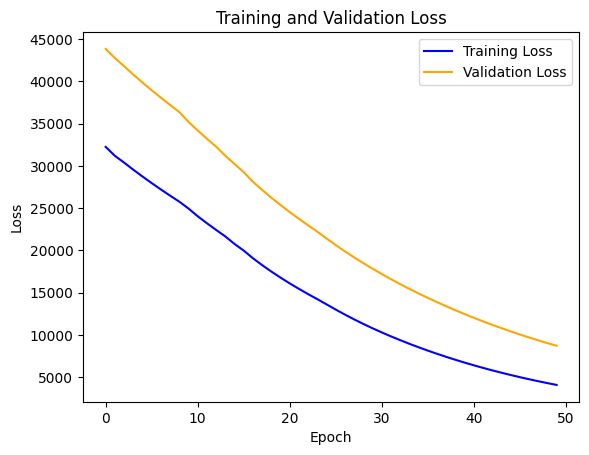

In [137]:
# build model
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(32),
                    layers.Dense(1)])

# compile model. select loss, optimizer, and learning rate
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.01),
              metrics=['mean_absolute_error'])

# fit model and set number of epochs
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

# plot loss per epoch
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Epoch 1/50


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 32959.6914 - mean_absolute_error: 180.9299 - val_loss: 45019.5117 - val_mean_absolute_error: 212.1077
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32317.1777 - mean_absolute_error: 179.1727 - val_loss: 44540.0039 - val_mean_absolute_error: 210.9743
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32053.7910 - mean_absolute_error: 178.4495 - val_loss: 43713.9844 - val_mean_absolute_error: 209.0074
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31318.3496 - mean_absolute_error: 176.3153 - val_loss: 41695.9883 - val_mean_absolute_error: 204.1230
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29173.8457 - mean_absolute_error: 170.1268 - val_loss: 38856.5859 - val_mean_absolute_error: 197.0445
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26170.9707 - mean_absolute_error: 161.0970 - val_loss: 33044.0508 - val_mean_absolute_error: 181.6957
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

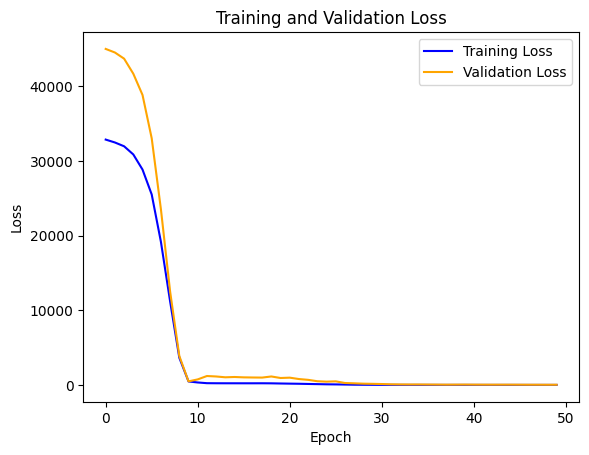

In [138]:
# tune model
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

# compile model. select loss, optimizer, and learning rate
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# fit model and set number of epochs
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

# plot loss per epoch
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [139]:
# get predictions
train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step


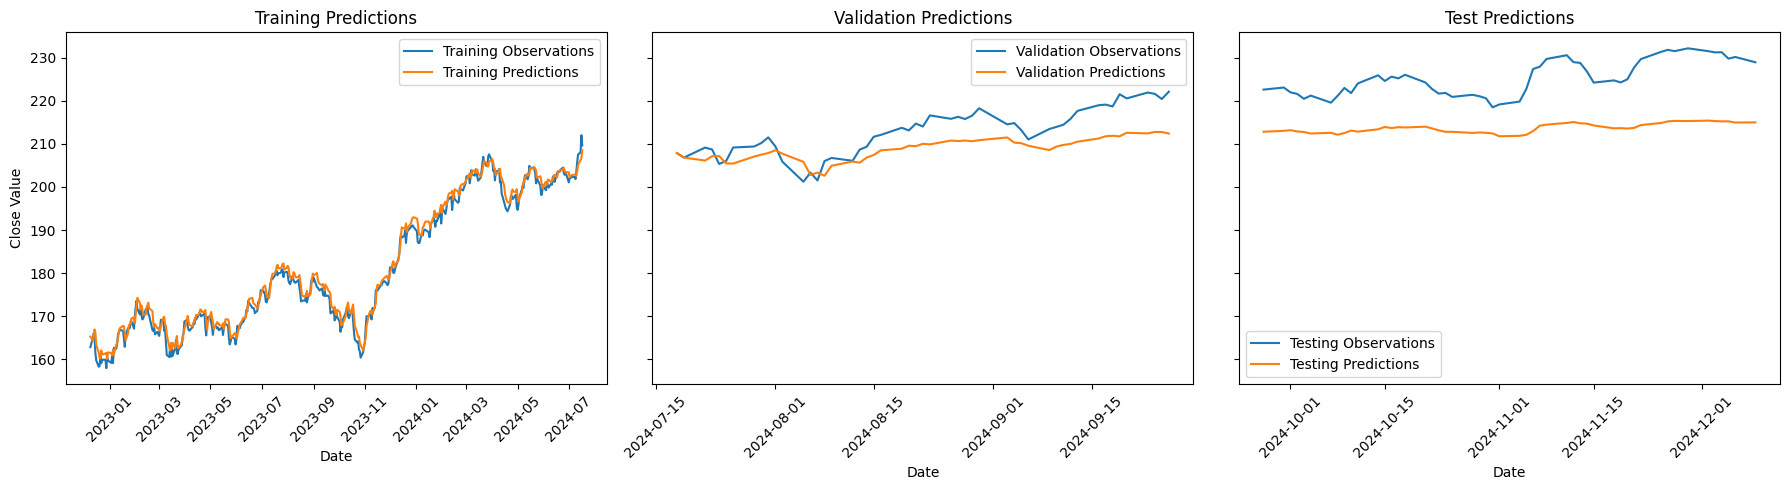

In [140]:
# 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)  # Share y-axis for easier comparison

# 1. plot training predictions
axes[0].plot(dates_train, y_train, label='Training Observations')
axes[0].plot(dates_train, train_predictions, label='Training Predictions')
axes[0].set_title('Training Predictions')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Close Value')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# 2. plot validation predictions
axes[1].plot(dates_val, y_val, label='Validation Observations')
axes[1].plot(dates_val, val_predictions, label='Validation Predictions')
axes[1].set_title('Validation Predictions')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

# 3. plot test predictions
axes[2].plot(dates_test, y_test, label='Testing Observations')
axes[2].plot(dates_test, test_predictions, label='Testing Predictions')
axes[2].set_title('Test Predictions')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Result

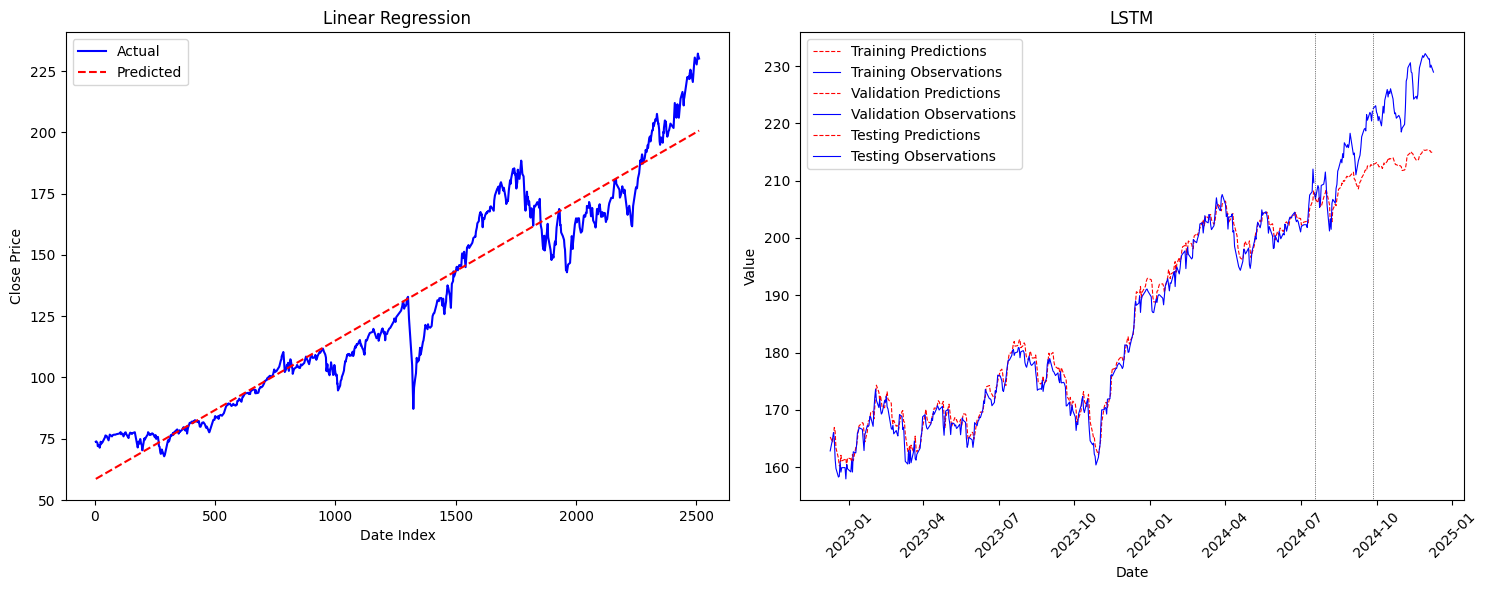

In [141]:
# create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. plot actual vs predicted
axes[0].plot(y_test_sorted.index, y_test_sorted, label='Actual', color='blue')
axes[0].plot(y_test_sorted.index, y_pred_sorted, label='Predicted', color='red', linestyle='--')
axes[0].set_title('Linear Regression')
axes[0].set_xlabel('Date Index')
axes[0].set_ylabel('Close Price')
axes[0].legend()

# 2. lstm predictions
axes[1].plot(dates_train, train_predictions, color='red', linestyle='--', linewidth=0.8)
axes[1].plot(dates_train, y_train, color='blue', linewidth=0.8)

axes[1].plot(dates_val, val_predictions, color='red', linestyle='--', linewidth=0.8)
axes[1].plot(dates_val, y_val, color='blue', linewidth=0.8)

axes[1].plot(dates_test, test_predictions, color='red', linestyle='--', linewidth=0.8)
axes[1].plot(dates_test, y_test, color='blue', linewidth=0.8)

# add a vertical dotted line between the training, validation, and test sets
split_train_val = dates_val[0]
split_val_test = dates_test[0]
axes[1].axvline(x=split_train_val, color='black', linestyle=':', linewidth=0.5)
axes[1].axvline(x=split_val_test, color='black', linestyle=':', linewidth=0.5)

axes[1].set_title('LSTM')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend(['Training Predictions',
                'Training Observations',
                'Validation Predictions', 
                'Validation Observations',
                'Testing Predictions', 
                'Testing Observations'])

# Rotate x-axis ticks
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [142]:
# create dictionary to store mse for lr and lstm models
model_scores = {
    'Model': ['Linear Regression', 'LSTM'],
    'Train': [
        mse(y_train_lr, lm.predict(X_train_lr)),
        history.history['loss'][-1]
    ],
    'Test': [
        mse(y_test_lr, lm.predict(X_test_lr)),
        mse(y_test, test_predictions)
    ]
}

# convert the dictionary to a df and print
model_scores_df = pd.DataFrame(model_scores)
model_scores_df.style.hide(axis="index")

Model,Train,Test
Linear Regression,138.619551,137.897163
LSTM,3.286796,143.644852


## Time Period Used: 5 Years

### Linear Regression

In [143]:
# set max date as end_date
end_date_3 = df_final.index.max()

# calculate start date
tentative_start_date_3 = end_date_3 - pd.DateOffset(years=5)  # select last 5 years

# find the closest valid start date
start_date_3 = df_final.index[df_final.index >= tentative_start_date_3].min()

start_date_3, end_date_3

(Timestamp('2019-12-09 00:00:00'), Timestamp('2024-12-09 00:00:00'))

In [144]:
# drop rows not in start and end range
df_lr = df_final[(df_final.index >= start_date_3) & (df_final.index <= end_date_3)]

df_lr

,avg_close
Date,
2019-12-09,124.155349
2019-12-10,124.135006
2019-12-11,124.554792
2019-12-12,125.001806
2019-12-13,125.174657
...,...
2024-12-03,231.248732
2024-12-04,231.289512
2024-12-05,229.800159


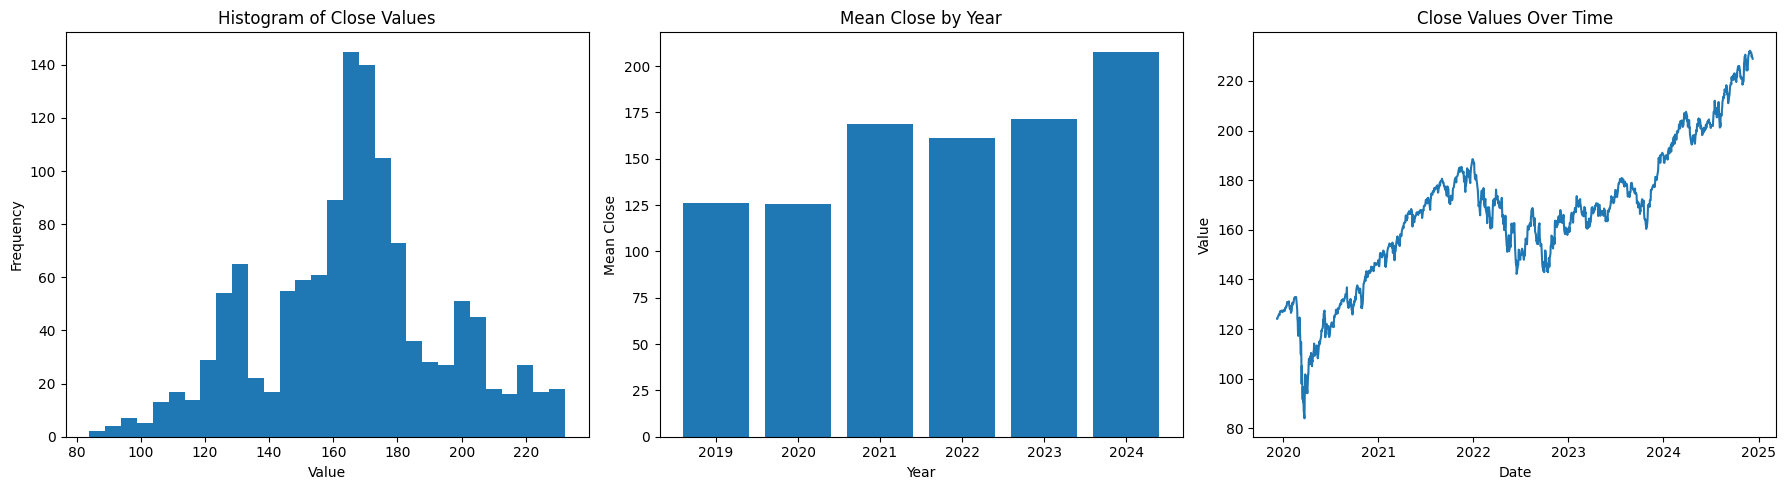

In [145]:
# create a 1x3 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # Adjust the figure size as needed

# plot histogram of close values
axs[0].hist(df_lr['avg_close'], bins=30)
axs[0].set_title('Histogram of Close Values')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

# plot histogram of mean close values by year
df_year = df_lr.copy()
df_year.loc[:, 'year'] = df_year.index.year

# group by year and calculate mean
data_grouped = df_year.groupby('year').mean()

axs[1].bar(data_grouped.index, data_grouped['avg_close'])
axs[1].set_title('Mean Close by Year')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Mean Close')

# plot the close values over time
axs[2].plot(df_lr.index, df_lr['avg_close'])
axs[2].set_title('Close Values Over Time')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [146]:
# split the data into train and test sets
df_lm = df_final.reset_index()
X = np.array(df_lm.index).reshape(-1,1)
Y = df_lm['avg_close']
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, Y, test_size=0.3, random_state=123)

In [147]:
print(X_train_lr.shape)
print(X_test_lr.shape)
print(y_train_lr.shape)
print(y_test_lr.shape)

(1759, 1)
(754, 1)
(1759,)
(754,)


In [148]:
# create linear model
lm = LinearRegression()
lm.fit(X_train_lr, y_train_lr)

LinearRegression()

In [149]:
# predict using the trained model
y_pred_lr = lm.predict(X_test_lr)

In [150]:
# sort index to maintain alignment with predictions
sorted_indices = np.argsort(X_test_lr.flatten())  # get sorted indices
y_test_sorted = y_test_lr.iloc[sorted_indices]    # sort test data
y_pred_sorted = y_pred_lr[sorted_indices]         # sort predictions

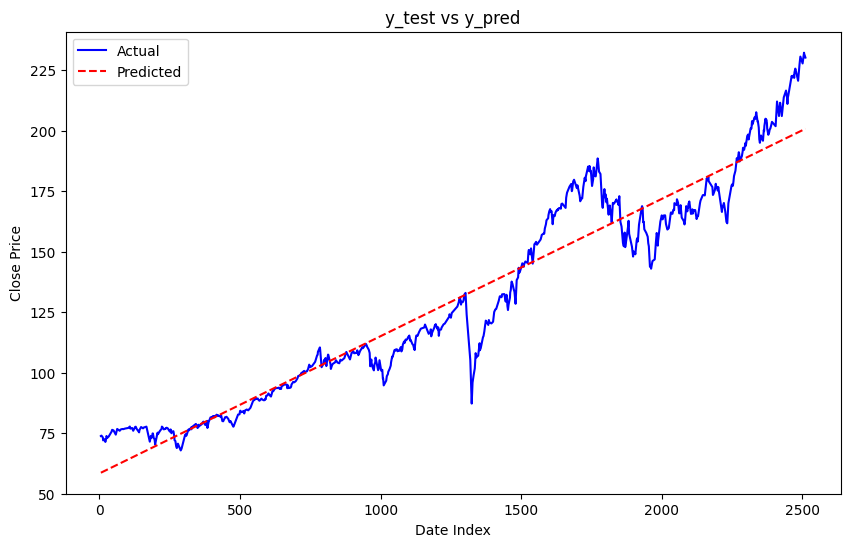

In [151]:
# plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_sorted.index, y_test_sorted, label='Actual', color='blue')
plt.plot(y_test_sorted.index, y_pred_sorted, label='Predicted', color='red', linestyle='--')

plt.title('y_test vs y_pred')
plt.xlabel('Date Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [152]:
# calculate scores and store them in a dictionary
evaluation_scores = {
    'Metric': ['r2_score', 'MSE'],
    'Train': [
        r2_score(y_train_lr, lm.predict(X_train_lr)),
        mse(y_train_lr, lm.predict(X_train_lr))
    ],
    'Test': [
        r2_score(y_test_lr, lm.predict(X_test_lr)),
        mse(y_test_lr, lm.predict(X_test_lr))
    ]
}

# convert the dictionary to a df and print
eval_scores_df = pd.DataFrame(evaluation_scores)
eval_scores_df.style.hide(axis="index")

Metric,Train,Test
r2_score,0.925407,0.924761
MSE,138.619551,137.897163


### LSTM

In [153]:
# convert start and end date to strings
end_date_str = end_date_3.strftime('%Y-%m-%d')
start_date_str = start_date_3.strftime('%Y-%m-%d')

In [154]:
# create lstm data structure
windowed_df = df_to_windowed_df(df_final, 
                                start_date_str, 
                                end_date_str, 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2019-12-09,123.567253,123.844034,124.615977,124.155349
1,2019-12-10,123.844034,124.615977,124.155349,124.135006
2,2019-12-11,124.615977,124.155349,124.135006,124.554792
3,2019-12-12,124.155349,124.135006,124.554792,125.001806
4,2019-12-13,124.135006,124.554792,125.001806,125.174657
...,...,...,...,...,...
1254,2024-12-03,231.535115,232.192305,231.537215,231.248732
1255,2024-12-04,232.192305,231.537215,231.248732,231.289512
1256,2024-12-05,231.537215,231.248732,231.289512,229.800159
1257,2024-12-06,231.248732,231.289512,229.800159,230.184870


In [155]:
# select target and feature variables
dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1259,), (1259, 3, 1), (1259,))

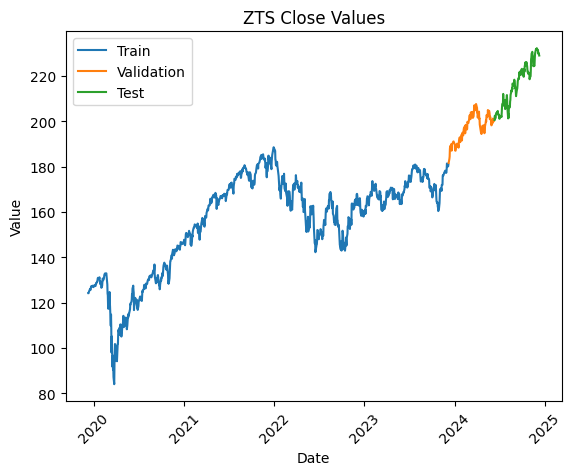

In [156]:
# split into training, validation, and test datasets
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]        # 80%

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]  # 10%
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]           # 10%

# plot the splits
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.title(f'{ticker} Close Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(['Train', 'Validation', 'Test'])

plt.xticks(rotation=45)
plt.show()

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 23991.1035 - mean_absolute_error: 153.3976 - val_loss: 35715.8203 - val_mean_absolute_error: 188.8940
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21830.0254 - mean_absolute_error: 146.2733 - val_loss: 33361.4922 - val_mean_absolute_error: 182.5558
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 19522.5156 - mean_absolute_error: 137.9374 - val_loss: 30854.2852 - val_mean_absolute_error: 175.5546
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 17899.8633 - mean_absolute_error: 132.0591 - val_loss: 28092.7285 - val_mean_absolute_error: 167.5048
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 15767.3672 - mean_absolute_error: 123.6829 - val_loss: 25772.4453 - val_mean_absolute_error: 160.4294
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 14163.7090 - mean_absolute_error: 117.0760 - val_loss: 23702.6270 - val_mean_absolute_error: 153.8433
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━

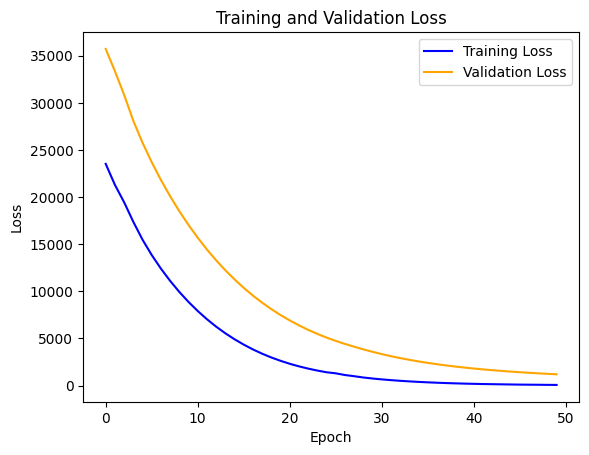

In [157]:
# build model
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(32),
                    layers.Dense(1)])

# compile model. select loss, optimizer, and learning rate
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.01),
              metrics=['mean_absolute_error'])

# fit model and set number of epochs
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

# plot loss per epoch
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 24541.1016 - mean_absolute_error: 155.2204 - val_loss: 37694.5000 - val_mean_absolute_error: 194.0609
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23300.5078 - mean_absolute_error: 151.0574 - val_loss: 32232.5762 - val_mean_absolute_error: 179.4369
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16821.9336 - mean_absolute_error: 127.1163 - val_loss: 11529.7676 - val_mean_absolute_error: 107.2149
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 2559.3364 - mean_absolute_error: 44.1867 - val_loss: 1345.7441 - val_mean_absolute_error: 36.1837
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 469.5494 - mean_absolute_error: 17.4299 - val_loss: 1922.2081 - val_mean_absolute_error: 43.4442
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 413.3567 - mean_absolute_error: 17.1669 - val_loss: 1503.3296 - val_mean_absolute_error: 38.3808
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/s

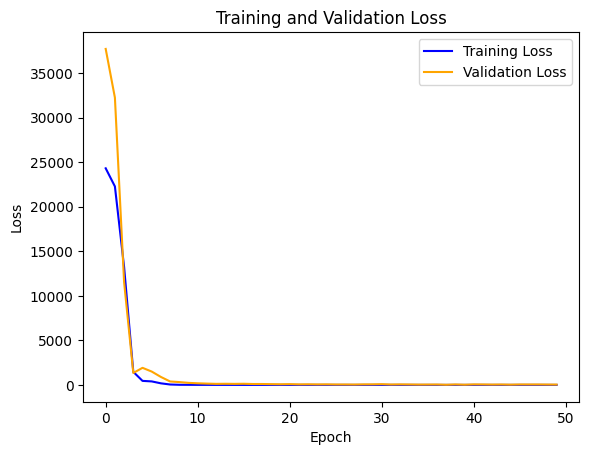

In [158]:
# tune model
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(32),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

# compile model. select loss, optimizer, and learning rate
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# fit model and set number of epochs
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

# plot loss per epoch
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [159]:
# get predictions
train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step


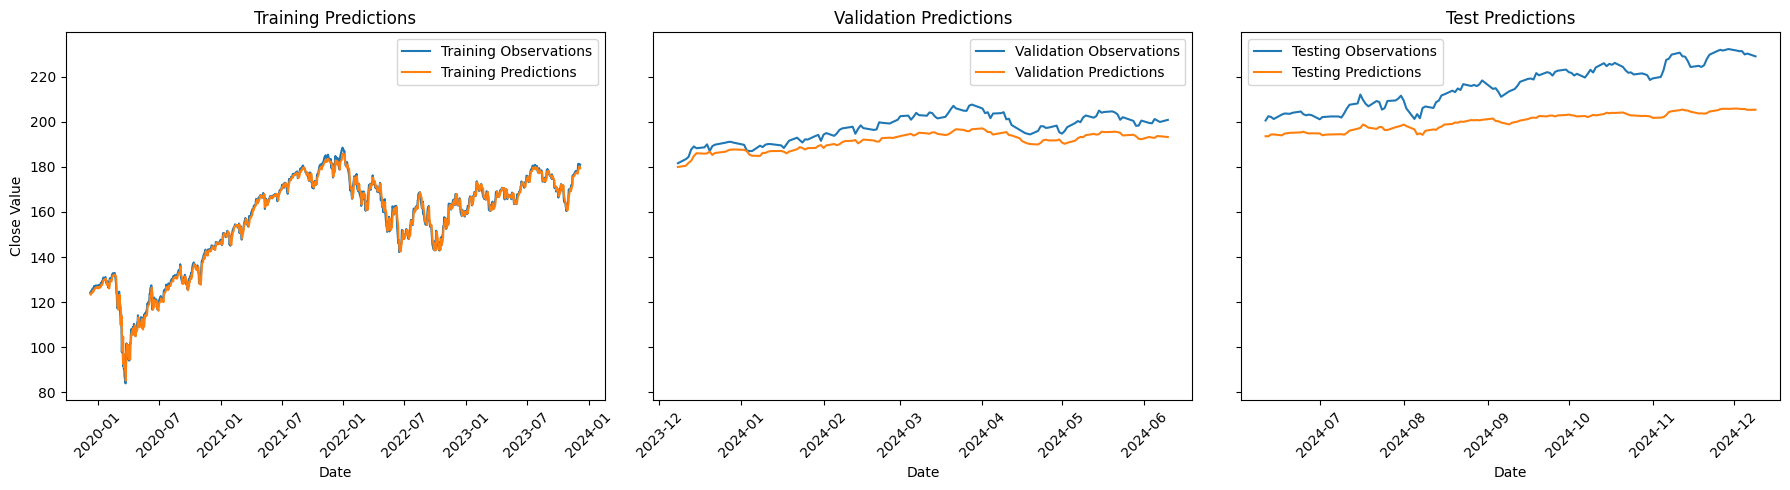

In [160]:
# 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)  # Share y-axis for easier comparison

# 1. plot training predictions
axes[0].plot(dates_train, y_train, label='Training Observations')
axes[0].plot(dates_train, train_predictions, label='Training Predictions')
axes[0].set_title('Training Predictions')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Close Value')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# 2. plot validation predictions
axes[1].plot(dates_val, y_val, label='Validation Observations')
axes[1].plot(dates_val, val_predictions, label='Validation Predictions')
axes[1].set_title('Validation Predictions')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

# 3. plot test predictions
axes[2].plot(dates_test, y_test, label='Testing Observations')
axes[2].plot(dates_test, test_predictions, label='Testing Predictions')
axes[2].set_title('Test Predictions')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Result

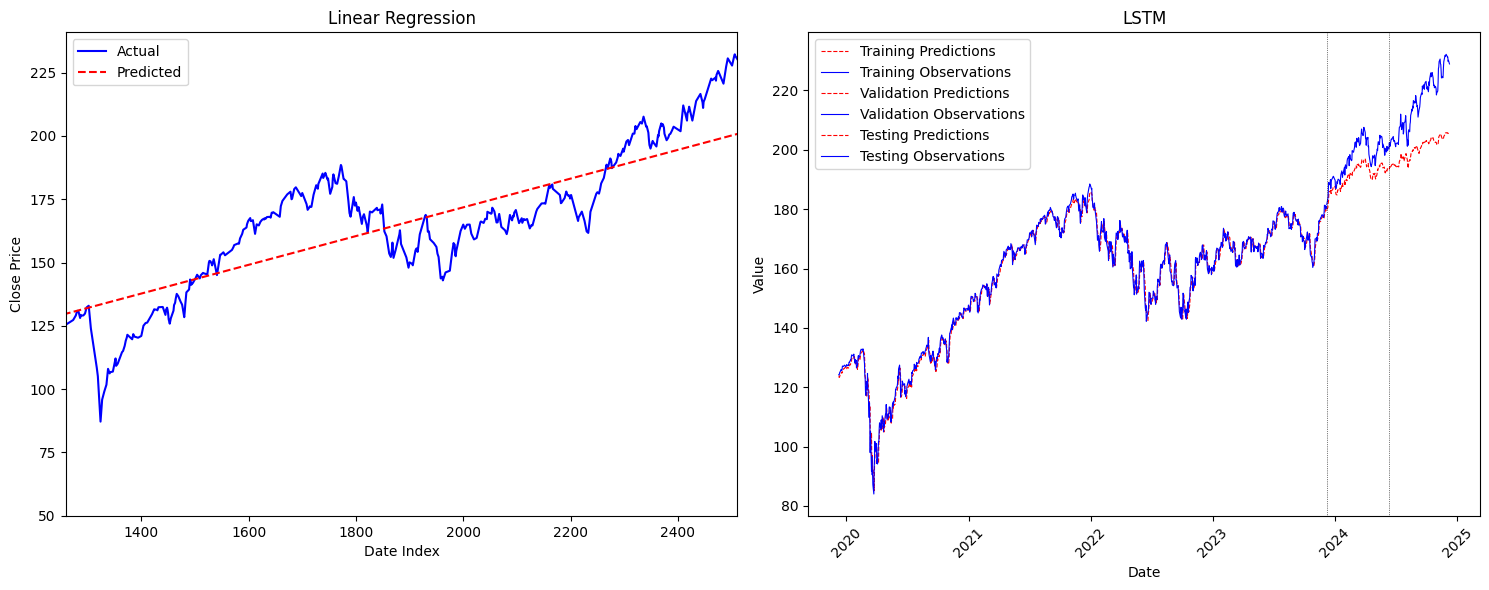

In [161]:
# create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. plot actual vs predicted
axes[0].plot(y_test_sorted.index, y_test_sorted, label='Actual', color='blue')
axes[0].plot(y_test_sorted.index, y_pred_sorted, label='Predicted', color='red', linestyle='--')
axes[0].set_title('Linear Regression')
axes[0].set_xlabel('Date Index')
axes[0].set_ylabel('Close Price')
axes[0].legend()

# limit x-axis to be same length as lstm graph
axes[0].set_xlim(y.shape[0], y_test_sorted.index[-1])

# 2. lstm predictions
axes[1].plot(dates_train, train_predictions, color='red', linestyle='--', linewidth=0.8)
axes[1].plot(dates_train, y_train, color='blue', linewidth=0.8)

axes[1].plot(dates_val, val_predictions, color='red', linestyle='--', linewidth=0.8)
axes[1].plot(dates_val, y_val, color='blue', linewidth=0.8)

axes[1].plot(dates_test, test_predictions, color='red', linestyle='--', linewidth=0.8)
axes[1].plot(dates_test, y_test, color='blue', linewidth=0.8)

# add a vertical dotted line between the training, validation, and test sets
split_train_val = dates_val[0]
split_val_test = dates_test[0]
axes[1].axvline(x=split_train_val, color='black', linestyle=':', linewidth=0.5)
axes[1].axvline(x=split_val_test, color='black', linestyle=':', linewidth=0.5)

axes[1].set_title('LSTM')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend(['Training Predictions', 
                'Training Observations',
                'Validation Predictions', 
                'Validation Observations',
                'Testing Predictions', 
                'Testing Observations'])

# Rotate x-axis ticks
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [162]:
# create dictionary to store mse for lr and lstm models
model_scores = {
    'Model': ['Linear Regression', 'LSTM'],
    'Train': [
        mse(y_train_lr, lm.predict(X_train_lr)),
        history.history['loss'][-1]
    ],
    'Test': [
        mse(y_test_lr, lm.predict(X_test_lr)),
        mse(y_test, test_predictions)
    ]
}

# convert the dictionary to a df and print
model_scores_df = pd.DataFrame(model_scores)
model_scores_df.style.hide(axis="index")

Model,Train,Test
Linear Regression,138.619551,137.897163
LSTM,4.248165,285.449097
